# Eksploracja danych
Zajmujemy się tutaj eksploracją i analizą danych w celu zbadania, które cechy URLów mogą być najbardziej przydatne do treningu sieci neuronowej.\
Wyniki uzyskane poniżej wykorzystaliśmy do oceny, które cechy będziemy wyciągać. Ten proces znajduje się w pliku fetaure_extraction.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
import os

In [2]:
# https://www.kaggle.com/datasets/hemanthpingali/phishing-url
df = pd.read_parquet("Training.parquet")
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,https://www.todayshomeowner.com/how-to-make-ho...,82,23,0,2,7,0,0,0,0,...,1,1,0,240,8892,67860,0,1,4,legitimate
1,http://thapthan.ac.th/information/confirmation...,93,14,1,2,0,0,0,0,0,...,1,0,1,0,2996,4189860,0,1,2,phishing
2,http://app.dialoginsight.com/T/OFC4/L2S/3888/B...,121,21,1,3,0,0,0,0,0,...,1,1,0,30,2527,346022,0,1,3,phishing
3,https://www.bedslide.com,24,16,0,2,0,0,0,0,0,...,0,0,0,139,7531,1059151,0,0,4,legitimate
4,https://tabs.ultimate-guitar.com/s/sex_pistols...,73,24,0,3,1,0,0,0,0,...,0,0,0,3002,7590,635,0,1,5,legitimate


Odrzucamy kolumny, w których wszystkie dane są równe zero.

In [3]:
zero_min_max_cols = df.columns[(df.min() == 0) & (df.max() == 0)]
zero_min_max_cols
df.drop(zero_min_max_cols, axis=1, inplace=True)

Konwersja zmiennej `status` na boolowski typ danych.

In [4]:
data = df.drop(['url'], axis = 1).copy()
data['status'] = data['status'].replace({'legitimate': 1, 'phishing': 0})

/var/folders/7y/z4ckz2m16zvb_lc_v2ddsc000000gn/T/ipykernel_1758/3207422848.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['status'] = data['status'].replace({'legitimate': 1, 'phishing': 0})


Badamy, ile danych odstających jest w każdej z cech.

In [5]:
outliers = {}
for i in range(data.shape[1]):
    zmienna = data[data.columns[i]]
    min_t = zmienna.mean() - (3 * zmienna.std())
    max_t = zmienna.mean() + (3 * zmienna.std())
    count = 0
    for j in zmienna:
        if j < min_t or j > max_t:
            count += 1
    procent = count/df.shape[0]*100
    outliers[data.columns[i]]= round(procent, 2)

outliers_sorted = dict(sorted(outliers.items(), key=lambda item: item[1], reverse=True))

for key, value in outliers_sorted.items():
    if value > 2:
    	print(f"{key}: {value}")

random_domain: 8.38
whois_registered_domain: 7.44
tld_in_path: 6.4
login_form: 6.31
tld_in_subdomain: 4.92
phish_hints: 4.37
ratio_extErrors: 3.56
web_traffic: 3.23
ratio_extRedirection: 2.94
statistical_report: 2.69
ratio_digits_host: 2.45
ratio_digits_url: 2.32
dns_record: 2.12
nb_hyphens: 2.1
shortest_words_raw: 2.1
abnormal_subdomain: 2.05
nb_at: 2.04


Poniżej znajdziemy listę cech, które wykazują wysoką (większą co do modułu od 0.2) korelację ze zmienną `status`.

In [6]:
cols = data.corr()[abs(data.corr()['status']) > 0.2]['status'].index
for i in range(len(cols)):
	if (i+1)%5 == 0:
		print()
	print(cols[i], end="; ")


length_url; length_hostname; ip; nb_qm; 
nb_eq; nb_slash; nb_www; ratio_digits_url; ratio_digits_host; 
tld_in_subdomain; prefix_suffix; shortest_word_host; longest_word_path; avg_word_path; 
phish_hints; nb_hyperlinks; ratio_intHyperlinks; empty_title; domain_in_title; 
domain_age; google_index; page_rank; status; 

In [7]:
data = data[cols]

Normalizacja danych.

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

for col in data.columns:
    data[col] = scaler.fit_transform(pd.DataFrame(data[col]))

Przechodzimy do zbudowania modelu `decision tree`, który zwraca ważność cech.

In [9]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=["status"])
y = data["status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [10]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [11]:
y_pred_train = rfc.predict(X_train)
y_pred = rfc.predict(X_test)

In [12]:
from sklearn import metrics

print("Train accuracy of the model: ", metrics.accuracy_score(y_train, y_pred_train))
print("Accuracy of the model: ", metrics.accuracy_score(y_test, y_pred))

Train accuracy of the model:  1.0
Accuracy of the model:  0.9640992167101827


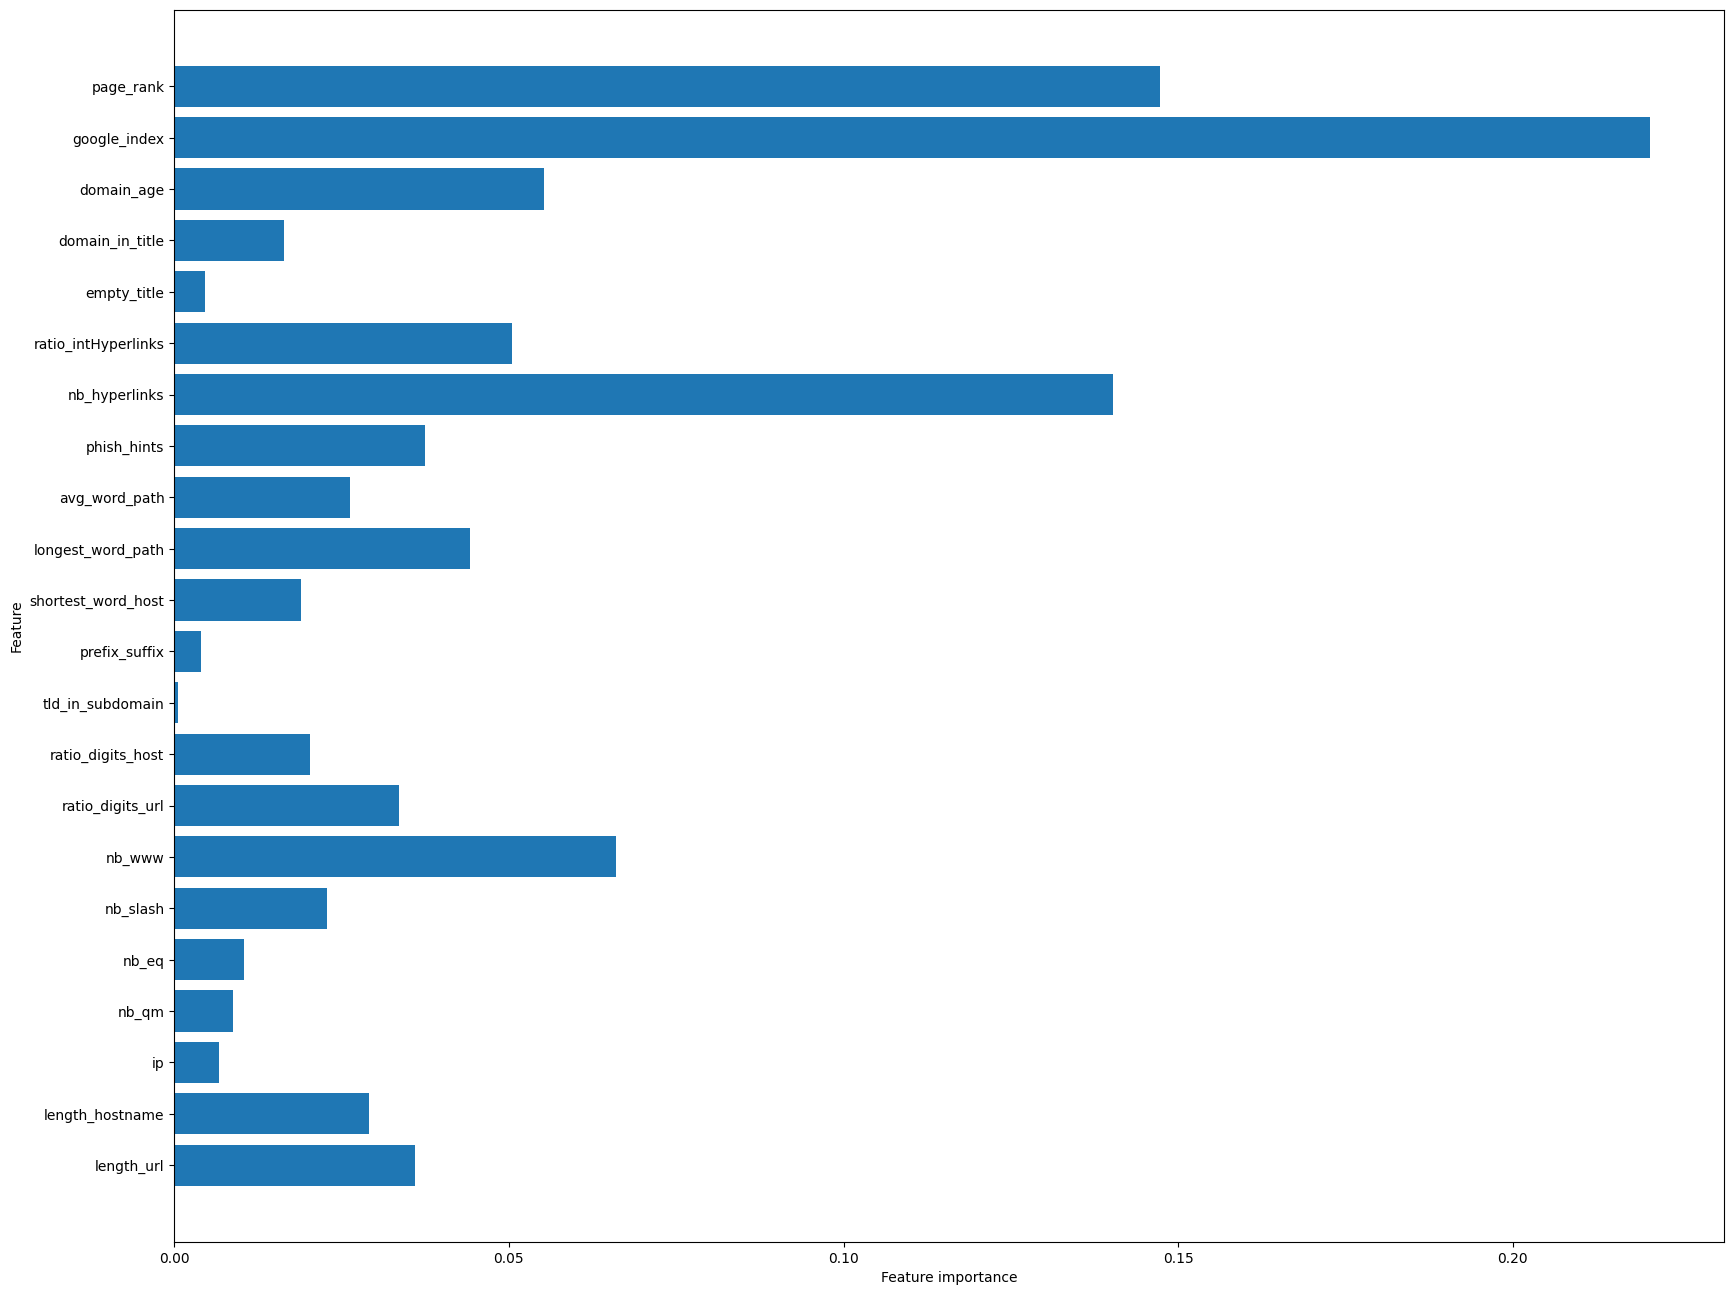

In [13]:
plt.figure(figsize=(20,16))
n_features = X_train.shape[1]
plt.barh(range(n_features), rfc.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()